# Analysis of the boxfiltered image data
- Preprocessing is complete, then now, obtain the thresholded binary image
- Threshold is obtained from the maximum count of the boxfiltered image

## First, test for a chosen tstr, zstr boxfiltered image

In [1]:
%matplotlib notebook

# Dependencies
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import cv2

from matplotlib import pyplot as plt

In [23]:
# Obtain the folder properties:
folder = "D:/Tolga/Colony Images/"
exp_name = "EQ59_Single_Colony_TilesScan.lif"

# Read the combined csv
combined_df = pd.read_csv(folder + exp_name + "/" + exp_name + "_combined.csv", index_col="Tp_id")
# Drop the NAN values
combined_df.dropna(inplace = True)
# Reorder in ascending time
combined_df.sort_values(by="time", ascending=True, inplace=True)
combined_df

,tix,plate_id,time,comment,max_filtered_counts,average_counts,acq_name,acq_type,base_folder
Tp_id,,,,,,,,,
1,0,2,13.866667,TileScan init_12h,8,0.056830,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
2,1,2,14.366667,TileScan init_12h,7,0.057373,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
3,2,2,14.866667,TileScan init_12h,9,0.059159,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
4,3,2,15.366667,TileScan init_12h,8,0.060877,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
5,4,2,15.866667,TileScan init_12h,10,0.064520,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
6,5,2,16.366667,TileScan init_12h,10,0.071765,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
7,6,2,16.866667,TileScan init_12h,10,0.081134,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
8,7,2,17.366667,TileScan init_12h,12,0.094280,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...
9,8,2,17.866667,TileScan init_12h,0,0.000000,EQ59_Single_Colony_TilesScan.lif_3dTimeScan_12...,xyzt,D:/Tolga/Colony Images/EQ59_Single_Colony_Tile...


In [24]:
# Select a timepoint
tpid = 29
timepoint = combined_df.loc[tpid]

base_folder = timepoint["base_folder"]
acq_name = timepoint["acq_name"]
acq_type = timepoint["acq_type"]
tix = timepoint["tix"]

In [25]:
# Read metadata for the chosen timepoint, and get the possible tstr and zstr values
metadata_folder = base_folder + "Metadata/"

tree = ET.parse(metadata_folder + f"{acq_name}_Properties.xml")    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree
image = root[0]

image_description = None
img_name = ""
xsz = ysz = zsz = ssz = tsz = -1
xvoxel = yvoxel = zvoxel = -1
for child in image:
    if child.tag == "ImageDescription":
        image_description = child
        for gchild in image_description:
            if gchild.tag == "Name":    # Name of the image
                img_name = gchild.text
            elif gchild.tag == "Dimensions":     # x,y,z,stage,t dimensions
                # Run through each deminson description
                for ggchild in gchild:
                    if ggchild.tag == "DimensionDescription":   # Check for tag
                        if ggchild.get("DimID") == "X":
                            xsz = int(ggchild.get("NumberOfElements"))
                            xvoxel = np.double(ggchild.get("Voxel"))
                        elif ggchild.get("DimID") == "Y":
                            ysz = int(ggchild.get("NumberOfElements"))
                            yvoxel = np.double(ggchild.get("Voxel"))
                        elif ggchild.get("DimID") == "Z":
                            zsz = int(ggchild.get("NumberOfElements"))
                            zvoxel = np.double(ggchild.get("Voxel"))
                        elif ggchild.get("DimID") == "Stage":
                            ssz = int(ggchild.get("NumberOfElements"))
                            svoxel = np.double(ggchild.get("Voxel"))
                        elif ggchild.get("DimID") == "T":
                            tsz = int(ggchild.get("NumberOfElements"))
                            # Note: tvoxel is not used!!
                            # Each image has its own timestamp data

# Check if all the values were updated
if tsz == -1:
    if acq_type == "xyzt":
        print("ERROR! Something is wrong. Couldn't find the number of timepoints")
    elif acq_type == "xyz":
        tsz = 1
    else:
        print("Undefined acq_type")

if zsz == -1:
    print("ERROR! Cannot find the z-stacks information. Check the filepath.")

## Read the chosen boxfiltered image in cv2

<IPython.core.display.Javascript object>


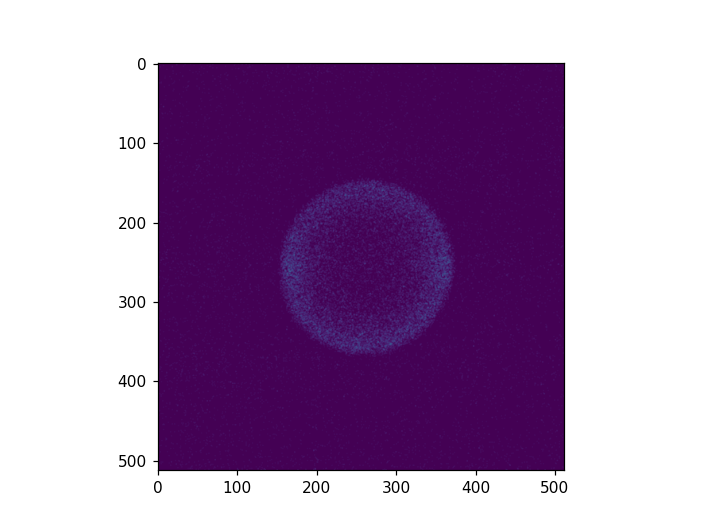

In [38]:
# Select a z-position
zix = 150
# Select a channel str
channel_str = "ch00"

zstr = None
if zsz > 100:
    zstr = "z%03d" % (zix)
elif zsz > 9:
    zstr = "z%02d" % (zix)

tstr = None
if acq_type == "xyzt":
    if tsz > 10:
        tstr = "t%02d" % (tix)
    elif tsz > 0:
        tstr = "t%01d" % (tix)

if tstr == None:
    boxfiltered_path = f"{base_folder}{channel_str}/Boxfiltered/{acq_name}_Boxfiltered_{zstr}_{channel_str}.tif"
else:
    if tpid < 10:
        boxfiltered_path = f"{base_folder}{channel_str}/Boxfiltered/3dTimeScan_12h_init_Boxfiltered_{tstr}_{zstr}_{channel_str}.tif"
    else:
        boxfiltered_path = f"{base_folder}{channel_str}/Boxfiltered/3dTimeScan_17h_init_long_Boxfiltered_{tstr}_{zstr}_{channel_str}.tif"
#     boxfiltered_path = f"{base_folder}{channel_str}/Boxfiltered/{acq_name}_Boxfiltered_{tstr}_{zstr}_{channel_str}.tif"

filtered = cv2.imread(boxfiltered_path, cv2.IMREAD_GRAYSCALE)
fig,ax = plt.subplots()

ax.imshow(cv2.resize(filtered/normalization_const, (512,512)), vmin=0, vmax=1)

In [35]:
boxfiltered_path

'D:/Tolga/Colony Images/EQ59_Single_Colony_TilesScan.lif/3dTimeScan_17h_init_long/ch00/Boxfiltered/EQ59_Single_Colony_TilesScan.lif_3dTimeScan_17h_init_long_Boxfiltered_t19_z050_ch00.tif'

## Now, for the given timepoint, save the normalized filtered movie of z-stacks after downsampling to (512,512)

In [39]:
# Normalization constant, the maximum filtered counts
normalization_const = timepoint["max_filtered_counts"].max()

# Select a timepoint
for tpid in combined_df.index:
    timepoint = combined_df.loc[tpid]

    base_folder = timepoint["base_folder"]
    acq_name = timepoint["acq_name"]
    acq_type = timepoint["acq_type"]
    tix = timepoint["tix"]
    
    # Read metadata for the chosen timepoint, and get the possible tstr and zstr values
    metadata_folder = base_folder + "Metadata/"

    tree = ET.parse(metadata_folder + f"{acq_name}_Properties.xml")    # xml tree of the current stage position
    root = tree.getroot()           # root of the xml tree
    image = root[0]

    image_description = None
    img_name = ""
    xsz = ysz = zsz = ssz = tsz = -1
    xvoxel = yvoxel = zvoxel = -1
    for child in image:
        if child.tag == "ImageDescription":
            image_description = child
            for gchild in image_description:
                if gchild.tag == "Name":    # Name of the image
                    img_name = gchild.text
                elif gchild.tag == "Dimensions":     # x,y,z,stage,t dimensions
                    # Run through each deminson description
                    for ggchild in gchild:
                        if ggchild.tag == "DimensionDescription":   # Check for tag
                            if ggchild.get("DimID") == "X":
                                xsz = int(ggchild.get("NumberOfElements"))
                                xvoxel = np.double(ggchild.get("Voxel"))
                            elif ggchild.get("DimID") == "Y":
                                ysz = int(ggchild.get("NumberOfElements"))
                                yvoxel = np.double(ggchild.get("Voxel"))
                            elif ggchild.get("DimID") == "Z":
                                zsz = int(ggchild.get("NumberOfElements"))
                                zvoxel = np.double(ggchild.get("Voxel"))
                            elif ggchild.get("DimID") == "Stage":
                                ssz = int(ggchild.get("NumberOfElements"))
                                svoxel = np.double(ggchild.get("Voxel"))
                            elif ggchild.get("DimID") == "T":
                                tsz = int(ggchild.get("NumberOfElements"))
                                # Note: tvoxel is not used!!
                                # Each image has its own timestamp data

    # Check if all the values were updated
    if tsz == -1:
        if acq_type == "xyzt":
            print("ERROR! Something is wrong. Couldn't find the number of timepoints")
        elif acq_type == "xyz":
            tsz = 1
        else:
            print("Undefined acq_type")

    if zsz == -1:
        print("ERROR! Cannot find the z-stacks information. Check the filepath.")
    
    
    # The suffix defining the timepoint as given by the microscope tilescan images
    tstr = None
    if acq_type == "xyzt":
        if tsz > 10:
            tstr = "t%02d" % (tix)
        elif tsz > 0:
            tstr = "t%01d" % (tix)

    # Suffix that comes to the end of the video filename
    tpstr = "Tp" + str(tpid)


    # Select a channel str
    channel_str = "ch00"
    # Video path to write
    video_path = folder + exp_name + "/Videos_unmarked/" + exp_name + "_" + tpstr + ".avi"
    # Video writer object
    out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'DIVX'), 4, (512,512))
    # Select a z-position
    for zix in range(zsz):
        print("tix = %d/%d, zix = %d/%d" % (tix, tsz, zix, zsz), end="   \r", flush=True)
        zstr = None
        if zsz > 100:
            zstr = "z%03d" % (zix)
        elif zsz > 9:
            zstr = "z%02d" % (zix)

        if tstr == None:
            boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_" + "Boxfiltered" + "_" + zstr + "_" + channel_str + ".tif"
        else:
            if tpid < 10:
                boxfiltered_path = f"{base_folder}{channel_str}/Boxfiltered/3dTimeScan_12h_init_Boxfiltered_{tstr}_{zstr}_{channel_str}.tif"
            else:
                boxfiltered_path = f"{base_folder}{channel_str}/Boxfiltered/3dTimeScan_17h_init_long_Boxfiltered_{tstr}_{zstr}_{channel_str}.tif"

#             boxfiltered_path = base_folder + channel_str + "/Boxfiltered/" + acq_name + "_" + "Boxfiltered" + "_" + tstr + "_" + zstr + "_" + channel_str + ".tif"

        # Read boxfiltered image
        filtered = cv2.imread(boxfiltered_path)
        # Normalize the filtered image with the normalization constant obtained from the maximum filtered count
        normalized = np.uint8(filtered/normalization_const*255)
        # Resize the image for outputting video
        resized = cv2.resize(normalized, (512,512))

        out.write(resized)

    out.release()

In [19]:
combined_df.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 29, 19, 20, 21, 28, 22, 23, 27, 24, 26, 25, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39],
           dtype='int64', name='Tp_id')

In [ ]:
out.release()

In [ ]:
folder

In [ ]:
tpstr = "Tp" + str(tpid)

In [ ]:
tpstr

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)